In [76]:
!pip install optuna
!pip install category_encoders
!pip install surprise
!pip install streamlit==1.24
!pip install prettytable
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
import subprocess
import sys
packages = ['optuna','shap','category_encoders', 'surprise', 'streamlit', 'prettytable']

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import pip
        pip.main(['install', package])
    finally:
        globals()[package] = importlib.import_module(package)

for package in packages:
  print(f'installing {package}')
  install_and_import(package)

installing optuna
installing shap


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting shap

Downloading shap-0.42.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)

Output()

Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from shap) (1.22.4)

Requirement already satisfied: scipy in /usr/local/lib/python3.10/dist-packages (from shap) (1.10.1)

Requirement already satisfied: scikit-learn in /usr/local/lib/python3.10/dist-packages (from shap) (1.2.2)

Requirement already satisfied: pandas in /usr/local/lib/python3.10/dist-packages (from shap) (1.5.3)

Requirement already satisfied: tqdm>=4.27.0 in /usr/local/lib/python3.10/dist-packages (from shap) (4.65.0)

Requirement already satisfied: packaging>20.9 in /usr/local/lib/python3.10/dist-packages (from shap) (23.1)

Collecting slicer==0.0.7 (from shap)

Downloading slicer-0.0.7-py3-none-any.whl (14 kB)

Requirement already satisfied: numba in /usr/local/lib/python3.10/dist-packages (from shap) (0.56.4)

Requirement already satisfied: cloudpickle in /usr/local/lib/python3.10/dist-packages (from shap) (2.2.1)

Requirement already satisfied: llvmlite<0.40,>=0.39.0dev0 in /usr/local/lib/python3.10/dist-packages (from numba->shap) (0.39.1)

Requirement already satisfied: setuptools in /usr/local/lib/python3.10/dist-packages (from numba->shap) (67.7.2)

Requirement already satisfied: python-dateutil>=2.8.1 in /usr/local/lib/python3.10/dist-packages (from pandas->shap) (2.8.2)

Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.10/dist-packages (from pandas->shap) (2022.7.1)

Requirement already satisfied: joblib>=1.1.1 in /usr/local/lib/python3.10/dist-packages (from scikit-learn->shap) (1.3.1)

Requirement already satisfied: threadpoolctl>=2.0.0 in /usr/local/lib/python3.10/dist-packages (from scikit-learn->shap) (3.2.0)

Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.10/dist-packages (from python-dateutil>=2.8.1->pandas->shap) (1.16.0)

Installing collected packages: slicer, shap

Successfully installed shap-0.42.1 slicer-0.0.7

installing category_encoders
installing surprise
installing streamlit
installing prettytable


In [77]:
## Support an helper functions
import pandas as pd
from sklearn import preprocessing
import category_encoders as ce
from prettytable import PrettyTable
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMRegressor
import numpy as np
from optuna.integration import LightGBMPruningCallback
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_log_error,mean_squared_error
from sklearn.model_selection import train_test_split
import shap

def convert_obj_to_str(X, obj_list, encoding_type='LBL' ):
  ''' function to convert '''
  if encoding_type.upper() == 'LBL' :
    enc = preprocessing.LabelEncoder()
  elif encoding_type.upper() == 'ONE':
    enc = preprocessing.OneHotEncoder()
  else:
    raise 'Undefined Encoder'

  for feature in obj_list:
    if X[feature].dtype.name == 'object':
      X[feature] = enc.fit_transform(X[feature].astype(str))

  return X

def find_float_features(data):
  ''' Will not work with dataset every thing is an object'''
  float_features = []
  for feature in data.columns:
     if data[feature].dtype.name == 'float':
        float_features.append(feature)
  return float_features


def fill_blanks(data , features ):
  for feature in features:
      data[feature]=data[feature].fillna( data[feature]).mode()
  return data


def fillna_w_func(data, features , func='mean'):

  for feature in features:
    if func == 'mean':
      data[feature].fillna(int(data[feature].mean()), inplace=True)
    elif func == 'medium':
      data[feature].fillna(int(data[feature].mean()), inplace=True)
    elif func == '':
      data[feature].fillna(int(data[feature].mean()), inplace=True)

  return data

def prep_X(data, object_features, type= 'train' ):
  if ( type.lower() == 'train'.lower() ):
  # remove the y column
      data = convert_obj_to_str(data [data.columns[:-1]], object_features)
      return data
  return convert_obj_to_str(data, object_features)

def build_features():
  object_features = ["MSZoning","Street","Alley","LotShape","LandContour","Utilities",
"LotConfig","LandSlope","Neighborhood","Condition1","Condition2","BldgType",
"HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType",
"ExterQual","ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure",
"BsmtFinType1","BsmtFinType2","Heating","HeatingQC","CentralAir","Electrical",
"KitchenQual","Functional","FireplaceQu","GarageType","GarageFinish",
"GarageQual","GarageCond","PavedDrive","PoolQC","Fence","MiscFeature",
"SaleType","SaleCondition"]

  float_features = ['LotArea','BsmtFinSF2','WoodDeckSF','GarageYrBlt','OpenPorchSF',
 'LotFrontage','TotalBsmtSF','3SsnPorch','KitchenAbvGr','HalfBath','EnclosedPorch',
 'BsmtFinSF1','2ndFlrSF','MasVnrArea','BedroomAbvGr','ScreenPorch','OverallQual',
 'MSSubClass','OverallCond','YearBuilt','GrLivArea','1stFlrSF','Fireplaces',
 'SalePrice','GarageArea','BsmtFullBath','PoolArea','YrSold','YearRemodAdd',
 'FullBath','LowQualFinSF','GarageCars','MiscVal','MoSold','BsmtUnfSF',
 'TotRmsAbvGrd','BsmtHalfBath', 'SalePrice']
  return { 'float' : float_features ,
           'object' : object_features
          }

# def drop_columns(data_df):
#    drop_list = ['Order', 'PID', 'Street', 'Land Contour', 'Neighborhood', 'Land Slope']
#    return data_df.drop(drop_list, inplace=True,axis =1 )

def prep_y(data) :
  return data[data.columns[-1]]

def prep_data(data_df,  data_type= 'train'):
  features_type = build_features()
  data_df = fillna_w_func (data_df , features_type['float'])
  data_df = fill_blanks(data_df , features_type['object'])
  return prep_X(data_df, features_type['object'], data_type ), prep_y(data_df)


In [ ]:
def lgbm_objective(trial, X , y ):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }
    model = LGBMRegressor(objective="regression", **param_grid)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    rmse_loss  = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(
            X_train,
            y_train
        )
        predicted_y = model.predict(X_test)
        cv_scores[idx] = metrics.r2_score(y_test, predicted_y)
        rmse_loss[idx] = metrics.mean_squared_log_error(y_test, predicted_y)

    return np.mean(cv_scores)


In [ ]:
def rf_objective(trial, X, y ):
  param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),

        "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_split": trial.suggest_int("min_samples_split", 3,12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf",20, 3000),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes",20, 3000),
        "oob_score" :trial.suggest_int("oob_score",False, True),
    }
  train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)

  model = RandomForestRegressor( **param_grid)
  model.fit(train_x, train_y)
  #model.train(param_grid, dtrain)
  preds = model.predict(valid_x)
  predicted_y = np.rint(preds)
  return metrics.r2_score(valid_y, predicted_y)

In [59]:
def dc_objective(trial, X, y ):
    param_grid = {

        "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_split": trial.suggest_int("min_samples_split", 3,12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf",20, 3000),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes",20, 3000),
    }
    model = DecisionTreeRegressor( **param_grid)
    model.fit(train_x, train_y)
    #model.train(param_grid, dtrain)
    preds = model.predict(valid_x)
    predicted_y = np.rint(preds)
    return metrics.r2_score(valid_y, predicted_y)

In [84]:
data_df = pd.read_csv('train.csv')
X, y = prep_data(data_df)
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [67]:
lgbm_study = optuna.create_study(direction="minimize", study_name="LGBM Regressor" )
lgbm_study.optimize(lambda trial: lgbm_objective(trial, X, y ), n_trials=40)
print (lgbm_study.best_params)
optuna.visualization.plot_optimization_history(lgbm_study)
optuna.visualization.plot_slice(lgbm_study)

[I 2023-07-23 16:48:19,746] A new study created in memory with name: LGBM Regressor
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7.634315463555122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.634315463555122
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction i

[I 2023-07-23 16:48:21,838] Trial 0 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0259281576978162, 'num_leaves': 1220, 'max_depth': 3, 'min_data_in_leaf': 4100, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 7.634315463555122, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.605115995184528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.605115995184528
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-07-23 16:48:23,629] Trial 1 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030050568776248933, 'num_leaves': 140, 'max_depth': 6, 'min_data_in_leaf': 2300, 'lambda_l1': 45, 'lambda_l2': 55, 'min_gain_to_split': 6.605115995184528, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=9.689530374366704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.689530374366704
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:48:25,574] Trial 2 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15150712181841408, 'num_leaves': 260, 'max_depth': 3, 'min_data_in_leaf': 7800, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 9.689530374366704, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.853387206623118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.853387206623118
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 wil

[I 2023-07-23 16:48:29,935] Trial 3 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05709160280152225, 'num_leaves': 2640, 'max_depth': 9, 'min_data_in_leaf': 5200, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 10.853387206623118, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.651057861671731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.651057861671731
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction i

[I 2023-07-23 16:48:31,908] Trial 4 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19743012076352268, 'num_leaves': 1440, 'max_depth': 12, 'min_data_in_leaf': 1800, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 6.651057861671731, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.1891635292569214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1891635292569214
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_frac

[I 2023-07-23 16:48:33,620] Trial 5 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2815936376969408, 'num_leaves': 620, 'max_depth': 7, 'min_data_in_leaf': 5000, 'lambda_l1': 45, 'lambda_l2': 100, 'min_gain_to_split': 1.1891635292569214, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.643040391556485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.643040391556485
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-07-23 16:48:35,189] Trial 6 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2042370977353509, 'num_leaves': 2080, 'max_depth': 4, 'min_data_in_leaf': 8700, 'lambda_l1': 70, 'lambda_l2': 40, 'min_gain_to_split': 2.643040391556485, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.9505480272392504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9505480272392504
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 wil

[I 2023-07-23 16:48:37,044] Trial 7 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22848605076366177, 'num_leaves': 2620, 'max_depth': 7, 'min_data_in_leaf': 3000, 'lambda_l1': 10, 'lambda_l2': 60, 'min_gain_to_split': 2.9505480272392504, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.863496286569985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.863496286569985
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction i

[I 2023-07-23 16:48:41,590] Trial 8 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01748217591729207, 'num_leaves': 640, 'max_depth': 12, 'min_data_in_leaf': 4800, 'lambda_l1': 0, 'lambda_l2': 25, 'min_gain_to_split': 13.863496286569985, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.1982609920135365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.1982609920135365
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:48:43,569] Trial 9 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1951954096720311, 'num_leaves': 2340, 'max_depth': 8, 'min_data_in_leaf': 9200, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 4.1982609920135365, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.2787053361042977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2787053361042977
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:48:46,710] Trial 10 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09489224415359519, 'num_leaves': 1460, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 100, 'lambda_l2': 5, 'min_gain_to_split': 0.2787053361042977, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.276039292614555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.276039292614555
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will 

[I 2023-07-23 16:48:48,597] Trial 11 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010286479270588872, 'num_leaves': 1040, 'max_depth': 5, 'min_data_in_leaf': 3300, 'lambda_l1': 50, 'lambda_l2': 65, 'min_gain_to_split': 6.276039292614555, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=8.049742190014367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.049742190014367
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will 

[I 2023-07-23 16:48:50,812] Trial 12 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08429079163858871, 'num_leaves': 140, 'max_depth': 3, 'min_data_in_leaf': 6700, 'lambda_l1': 35, 'lambda_l2': 80, 'min_gain_to_split': 8.049742190014367, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.818246130620609, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.818246130620609
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be

[I 2023-07-23 16:48:55,703] Trial 13 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05440123359606094, 'num_leaves': 920, 'max_depth': 6, 'min_data_in_leaf': 2800, 'lambda_l1': 70, 'lambda_l2': 0, 'min_gain_to_split': 4.818246130620609, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.369319278549375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.369319278549375
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be

[I 2023-07-23 16:48:57,578] Trial 14 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12004319424743641, 'num_leaves': 1740, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 60, 'lambda_l2': 55, 'min_gain_to_split': 8.369319278549375, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=5.733844296736368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.733844296736368
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction i

[I 2023-07-23 16:48:59,756] Trial 15 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03394576262917958, 'num_leaves': 20, 'max_depth': 5, 'min_data_in_leaf': 4300, 'lambda_l1': 35, 'lambda_l2': 75, 'min_gain_to_split': 5.733844296736368, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.556854166720849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.556854166720849
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[I 2023-07-23 16:49:01,657] Trial 16 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05731688892477206, 'num_leaves': 1200, 'max_depth': 3, 'min_data_in_leaf': 6400, 'lambda_l1': 90, 'lambda_l2': 45, 'min_gain_to_split': 7.556854166720849, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.427515294638948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.427515294638948
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 wil

[I 2023-07-23 16:49:08,896] Trial 17 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10045677236098247, 'num_leaves': 520, 'max_depth': 6, 'min_data_in_leaf': 1400, 'lambda_l1': 35, 'lambda_l2': 10, 'min_gain_to_split': 10.427515294638948, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.0613805129127245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0613805129127245
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fracti

[I 2023-07-23 16:49:10,846] Trial 18 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.012859647367988412, 'num_leaves': 1980, 'max_depth': 10, 'min_data_in_leaf': 3700, 'lambda_l1': 50, 'lambda_l2': 90, 'min_gain_to_split': 5.0613805129127245, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=9.1891534242827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.1891534242827
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is 

[I 2023-07-23 16:49:14,130] Trial 19 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047467839907349055, 'num_leaves': 2880, 'max_depth': 4, 'min_data_in_leaf': 2200, 'lambda_l1': 65, 'lambda_l2': 70, 'min_gain_to_split': 9.1891534242827, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=6.904654401299869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.904654401299869
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:49:16,380] Trial 20 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07968050615681634, 'num_leaves': 440, 'max_depth': 8, 'min_data_in_leaf': 6200, 'lambda_l1': 80, 'lambda_l2': 50, 'min_gain_to_split': 6.904654401299869, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=9.566379436696382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.566379436696382
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:49:21,352] Trial 21 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14071426635863205, 'num_leaves': 280, 'max_depth': 3, 'min_data_in_leaf': 7600, 'lambda_l1': 25, 'lambda_l2': 20, 'min_gain_to_split': 9.566379436696382, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.90691574967498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.90691574967498
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be i

[I 2023-07-23 16:49:23,229] Trial 22 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15284837882282534, 'num_leaves': 860, 'max_depth': 4, 'min_data_in_leaf': 9900, 'lambda_l1': 0, 'lambda_l2': 30, 'min_gain_to_split': 11.90691574967498, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.967448716707705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.967448716707705
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:49:25,207] Trial 23 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12329072282431494, 'num_leaves': 280, 'max_depth': 3, 'min_data_in_leaf': 3900, 'lambda_l1': 30, 'lambda_l2': 15, 'min_gain_to_split': 7.967448716707705, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.23343389997937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.23343389997937
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is 

[I 2023-07-23 16:49:27,102] Trial 24 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036456107975606805, 'num_leaves': 20, 'max_depth': 6, 'min_data_in_leaf': 7800, 'lambda_l1': 45, 'lambda_l2': 10, 'min_gain_to_split': 9.23343389997937, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=6.964735429554818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.964735429554818
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:49:29,277] Trial 25 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08211831104465336, 'num_leaves': 1220, 'max_depth': 4, 'min_data_in_leaf': 5600, 'lambda_l1': 20, 'lambda_l2': 50, 'min_gain_to_split': 6.964735429554818, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.797565048530566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.797565048530566
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction i

[I 2023-07-23 16:49:33,971] Trial 26 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06824595341179795, 'num_leaves': 760, 'max_depth': 5, 'min_data_in_leaf': 2400, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 5.797565048530566, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.280262645350676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.280262645350676
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fracti

[I 2023-07-23 16:49:36,044] Trial 27 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03197581927511585, 'num_leaves': 340, 'max_depth': 4, 'min_data_in_leaf': 1300, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 12.280262645350676, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=8.973985249012273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.973985249012273
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be

[I 2023-07-23 16:49:37,893] Trial 28 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11170525782994098, 'num_leaves': 1100, 'max_depth': 3, 'min_data_in_leaf': 4300, 'lambda_l1': 60, 'lambda_l2': 0, 'min_gain_to_split': 8.973985249012273, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.276733473135682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.276733473135682
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 wil

[I 2023-07-23 16:49:39,686] Trial 29 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06577348360229618, 'num_leaves': 1760, 'max_depth': 9, 'min_data_in_leaf': 7100, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 11.276733473135682, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=10.215549841272344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.215549841272344
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 wil

[I 2023-07-23 16:49:41,999] Trial 30 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13887384235624983, 'num_leaves': 680, 'max_depth': 6, 'min_data_in_leaf': 5600, 'lambda_l1': 20, 'lambda_l2': 20, 'min_gain_to_split': 10.215549841272344, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.489172359846375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.489172359846375
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-07-23 16:49:43,636] Trial 31 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04268735219423882, 'num_leaves': 2420, 'max_depth': 10, 'min_data_in_leaf': 8200, 'lambda_l1': 15, 'lambda_l2': 15, 'min_gain_to_split': 7.489172359846375, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.446823288163642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.446823288163642
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 wil

[I 2023-07-23 16:49:48,069] Trial 32 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06522461224852383, 'num_leaves': 2860, 'max_depth': 9, 'min_data_in_leaf': 5000, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split': 10.446823288163642, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.741514091174837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.741514091174837
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be i

[I 2023-07-23 16:49:49,864] Trial 33 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028589168649480006, 'num_leaves': 1600, 'max_depth': 11, 'min_data_in_leaf': 5600, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 8.741514091174837, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.736865994655127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.736865994655127
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[I 2023-07-23 16:49:51,818] Trial 34 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0478709195998462, 'num_leaves': 2080, 'max_depth': 7, 'min_data_in_leaf': 1700, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 6.736865994655127, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=13.045415931757478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.045415931757478
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-07-23 16:49:53,422] Trial 35 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028826726945429024, 'num_leaves': 1280, 'max_depth': 9, 'min_data_in_leaf': 3100, 'lambda_l1': 45, 'lambda_l2': 20, 'min_gain_to_split': 13.045415931757478, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=14.488109677693515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.488109677693515
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:49:55,467] Trial 36 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16794305023481357, 'num_leaves': 2700, 'max_depth': 8, 'min_data_in_leaf': 9100, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 14.488109677693515, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.119740142869109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.119740142869109
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be

[I 2023-07-23 16:49:59,847] Trial 37 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010403030647534527, 'num_leaves': 2260, 'max_depth': 12, 'min_data_in_leaf': 4400, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 11.119740142869109, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=9.818625200978099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.818625200978099
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction

[I 2023-07-23 16:50:01,823] Trial 38 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27977990994735213, 'num_leaves': 460, 'max_depth': 7, 'min_data_in_leaf': 3400, 'lambda_l1': 20, 'lambda_l2': 10, 'min_gain_to_split': 9.818625200978099, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -0.0035774435875945533.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.402390213809786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.402390213809786
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM

[I 2023-07-23 16:50:03,920] Trial 39 finished with value: -0.0035774435875945533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09338605548639303, 'num_leaves': 1880, 'max_depth': 11, 'min_data_in_leaf': 2500, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 8.402390213809786, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: -0.0035774435875945533.


{'n_estimators': 10000, 'learning_rate': 0.0259281576978162, 'num_leaves': 1220, 'max_depth': 3, 'min_data_in_leaf': 4100, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 7.634315463555122, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}


In [ ]:

rf_study = optuna.create_study(direction="minimize", study_name="Random Forrest Regressor" )
rf_study.optimize(lambda trial: rf_objective(trial, X, y), n_trials=10)
print (rf_study.best_params)
optuna.visualization.plot_optimization_history(rf_study)
optuna.visualization.plot_slice(rf_study)

[I 2023-07-23 16:20:29,410] A new study created in memory with name: Random Forrest Regressor
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
[I 2023-07-23 16:21:11,150] Trial 0 finished with value: -0.026395338592549278 and parameters: {'n_estimators': 10000, 'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 913, 'max_leaf_nodes': 1544, 'oob_score': 1}. Best is trial 0 with value: -0.026395338592549278.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
[I 2023-07-23 16:21:39,217] Trial 1 finished with value: -0.027369278763679228 and parameters: {'n_estimators': 10000, 'criterion': 'absolute_err

{'n_estimators': 10000, 'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2526, 'max_leaf_nodes': 2112, 'oob_score': 0}


In [62]:

dc_study = optuna.create_study(direction="minimize", study_name="Deciontree Regressor" )
dc_study.optimize(lambda trial: dc_objective(trial, X, y), n_trials=40)
print (dc_study.best_params)
optuna.visualization.plot_optimization_history(dc_study)
optuna.visualization.plot_slice(dc_study)

[I 2023-07-23 16:42:27,868] A new study created in memory with name: Deciontree Regressor
[I 2023-07-23 16:42:27,893] Trial 0 finished with value: 0.3393195535547664 and parameters: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 517, 'max_leaf_nodes': 1550}. Best is trial 0 with value: 0.3393195535547664.
[I 2023-07-23 16:42:27,903] Trial 1 finished with value: -0.002227919484113494 and parameters: {'criterion': 'poisson', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 1480, 'max_leaf_nodes': 2760}. Best is trial 1 with value: -0.002227919484113494.
[I 2023-07-23 16:42:27,912] Trial 2 finished with value: -0.002227919484113494 and parameters: {'criterion': 'squared_error', 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1779, 'max_leaf_nodes': 2623}. Best is trial 1 with value: -0.002227919484113494.
[I 2023-07-23 16:42:27,925] Trial 3 finished with value: -0.08221153048695329 and parameters: {'criterion': 'absolute_erro

{'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2985, 'max_leaf_nodes': 2895}


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [91]:
## Best Params from the study
## {'n_estimators': 10000, 'learning_rate': 0.0259281576978162, 'num_leaves': 1220,
# 'max_depth': 3, 'min_data_in_leaf': 4100, 'lambda_l1': 30, 'lambda_l2': 20, 'min_gain_to_split': 7.634315463555122, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}
model = LGBMRegressor(n_estimators =  10000,
    criterion= 'absolute_error', max_depth = 3
    , lambda_l1 =30, lambda_l2 = 20, min_gain_to_split = 7.634315463555122
    , bagging_freq = 1, feature_fraction = 0.4    ,
    learning_rate = 0.0259281576978162)
model.fit(X_train, y_train )
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("LGBMRegressor - Mean Squared Error: {:,.2f}".format (mse))

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_gain_to_split is set=7.634315463555122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.634315463555122
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMRegressor - Mean Squared Error: 1,489,559,647.63


In [92]:
## Best params from the study
## {'n_estimators': 10000, 'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2526, 'max_leaf_nodes': 2112, 'oob_score': 0}
model = RandomForestRegressor(n_estimators =  10000,
    criterion= 'absolute_error', max_depth = 6,
    min_samples_split = 8, min_samples_leaf = 2526, max_leaf_nodes = 2112, oob_score= 0)
model.fit(X_train, y_train )
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor - Mean Squared Error: {:,.2f}".format (mse))


Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.


RandomForestRegressor - Mean Squared Error: 7,596,139,801.11


In [93]:
##{'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_split': 10,
## 'min_samples_leaf': 2985, 'max_leaf_nodes': 2895}
##
model = DecisionTreeRegressor(
    criterion= 'absolute_error', max_depth = 7,
    min_samples_split = 10, min_samples_leaf = 2985, max_leaf_nodes = 2895)
model.fit(X_train, y_train )
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("DecisionTreeRegressor - Mean Squared Error: {:,.2f}".format (mse))

DecisionTreeRegressor - Mean Squared Error: 7,586,972,381.89


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


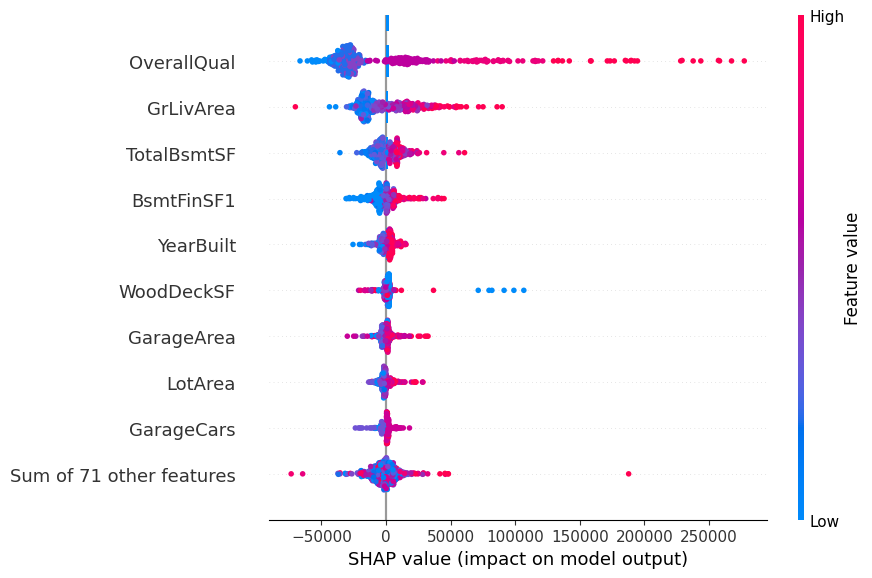

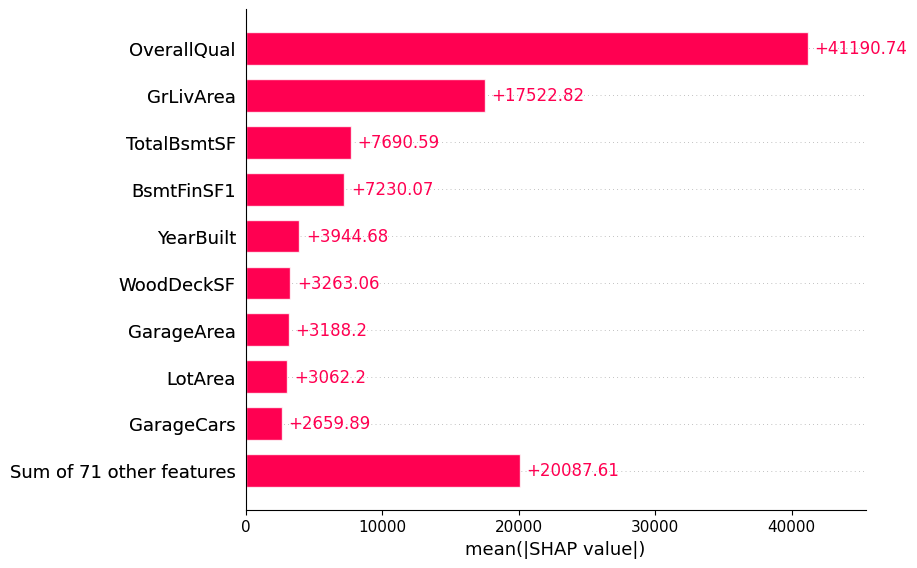

In [103]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# print (shap_values )
model = DecisionTreeRegressor()
model.fit(X_train, y_train )


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
shap.plots.beeswarm(shap_values )
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


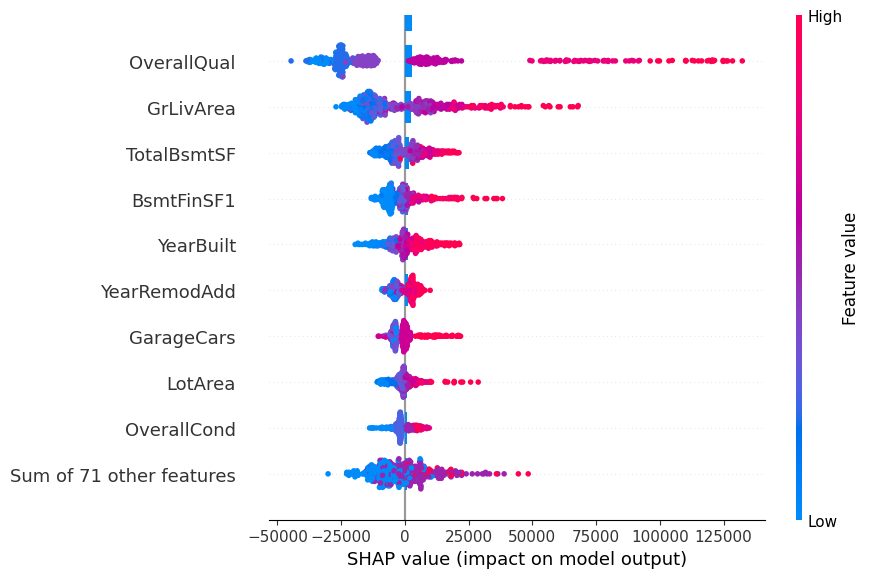

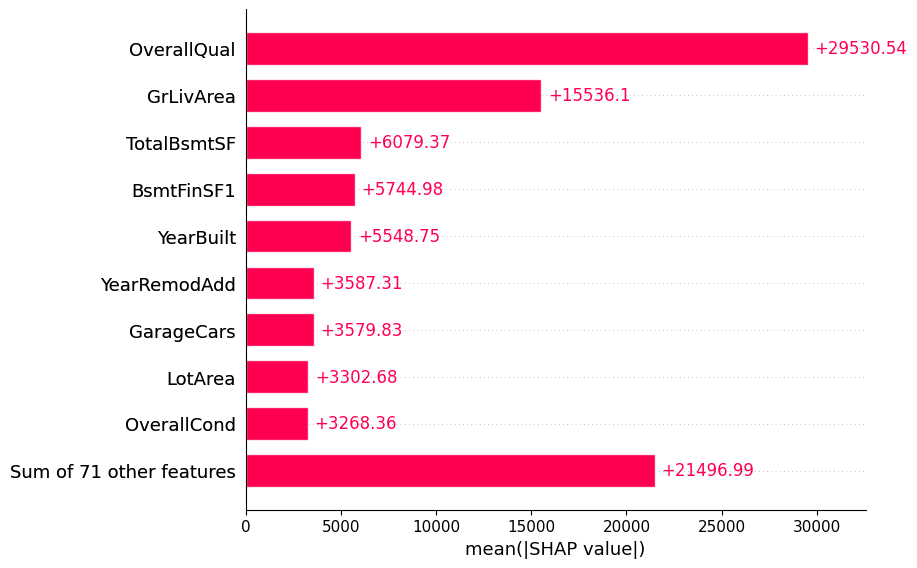

In [104]:
## SHAP With LGBMRegressor
model = LGBMRegressor()
model.fit(X_train, y_train )


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
shap.plots.beeswarm(shap_values )
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


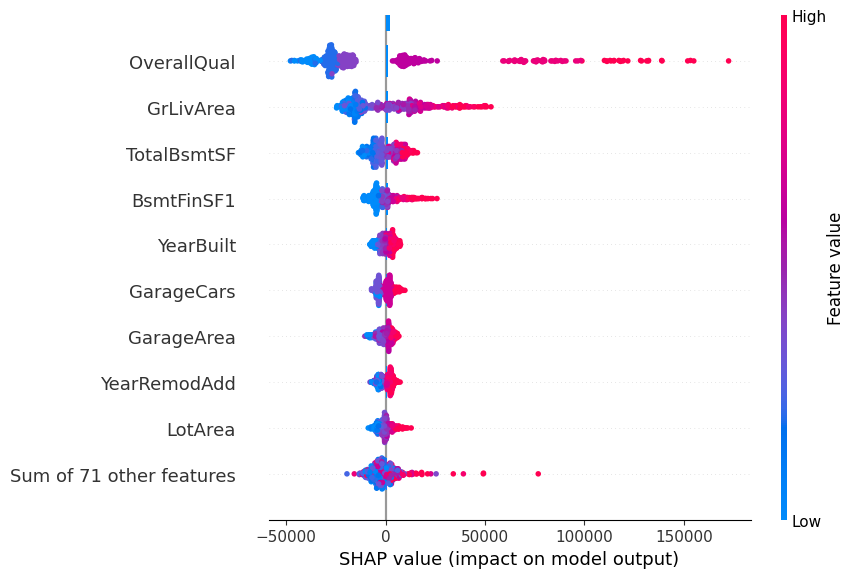

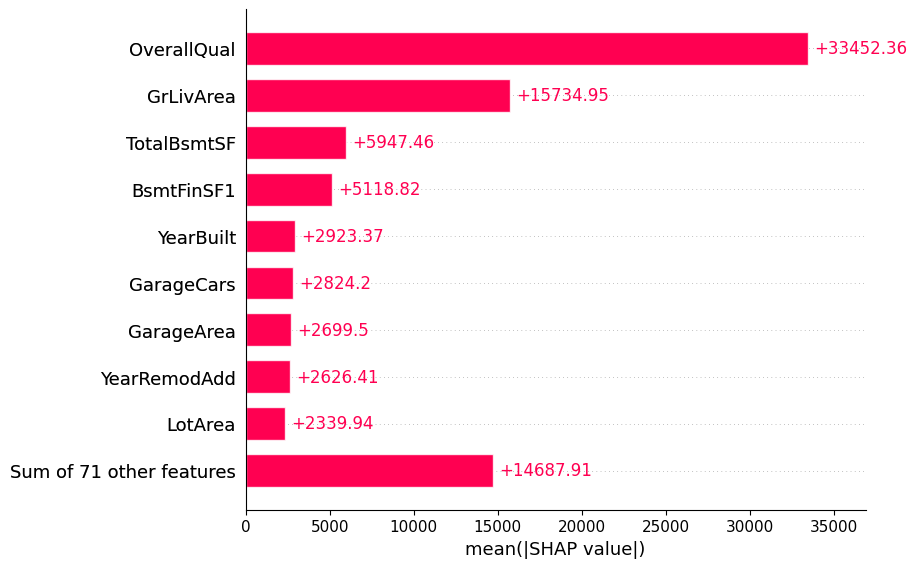

In [105]:
## SHAP With RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train )


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
shap.plots.beeswarm(shap_values )
shap.plots.bar(shap_values)

In [106]:
X_test =X_test[['MSSubClass','OverallQual','GrLivArea','TotalBsmtSF','GarageCars',
 'BsmtFinSF1','1stFlrSF','2ndFlrSF','YearRemodAdd','YearBuilt','LotArea',
 'Fireplaces','FullBath', 'HalfBath']]
X_train =X_train[['MSSubClass','OverallQual','GrLivArea','TotalBsmtSF','GarageCars',
 'BsmtFinSF1','1stFlrSF','2ndFlrSF','YearRemodAdd','YearBuilt','LotArea',
 'Fireplaces','FullBath', 'HalfBath']]

Given than the top Features with all 3 Regressors are

Idx | Important Features
--- | ---
1|GrLivArea
2|TotalBsmtSF
3|BsmtFinSF1
4|YearBuilt
5|GarageCars
6|GarageArea
7|YearRemodAdd
8|LotArea
9|OverAllCond
10|Fireplaces
11|1stFlrSF
12|2ndFlrSF
13|FullBatch
14|HalFBath
15|MSSubClass

with the following performance

Idx | Regressors | MSE Value
--- | --- | ---
1 | LGBMRegressor |  1,489,559,647.63
2 | RandomForestRegressor |  7,596,139,801.11
3 | DecisionTreeRegressor |  7,586,972,381.89


We will create a model for Execution with the important attributes only for the streamlit application

In [109]:
import pickle
dc_model = DecisionTreeRegressor(
    criterion= 'absolute_error', max_depth = 7,
    min_samples_split = 10, min_samples_leaf = 2985, max_leaf_nodes = 2895)
dc_model.fit(X_train, y_train )
pickle.dump(dc_model, open('dc_model.pk1', 'wb'))

rf_model = RandomForestRegressor(n_estimators =  10000,
    criterion= 'absolute_error', max_depth = 6,
    min_samples_split = 8, min_samples_leaf = 2526, max_leaf_nodes = 2112, oob_score= 0)
rf_model.fit(X_train, y_train )
pickle.dump(rf_model, open('rf_model.pk1', 'wb'))

lgbm_model = LGBMRegressor(n_estimators =  10000,
    criterion= 'absolute_error', max_depth = 3
    , lambda_l1 =30, lambda_l2 = 20, min_gain_to_split = 7.634315463555122
    , bagging_freq = 1, feature_fraction = 0.4    ,
    learning_rate = 0.0259281576978162)
lgbm_model.fit(X_train, y_train )
pickle.dump(lgbm_model, open('lgbm_model_model.pk1', 'wb'))


#model = pickle.load(open(pickle_model,'rb'))

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
